# openelec example walkthrough
This notebook goes through the main functionality of the openelec model.
There is more lurking in the code but this should get you started.

In [1]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

from openelec.clustering import prepare_clusters
from openelec.local import LocalModel
from openelec.national import NationalModel
from openelec import io

In [2]:
# Hide Fiona warnings
import warnings
warnings.simplefilter("ignore")

### Set input and output folders

In [3]:
test_data = Path('test_data')
test_output = Path('test_output')

# Prepare clusters

In [4]:
country = 'Lesotho'
ghs_in = test_data / 'ghs.tif'
gdp_in = test_data / 'gdp.tif'
travel_in = test_data / 'travel.tif'
ntl_in = test_data / 'ntl.tif'
aoi_in = test_data / 'gadm.gpkg'
grid_in = test_data / 'grid.gpkg'

clusters_out = test_output / 'clusters.geojson'

clusters = prepare_clusters(country,
                            ghs_in=ghs_in,
                            gdp_in=gdp_in,
                            travel_in=travel_in,
                            ntl_in=ntl_in,
                            aoi_in=aoi_in,
                            grid_in=grid_in,
                            clusters_out=clusters_out)   



--- Lesotho ---


Clipping raster...
 -- Shape: (987, 919)
-- Affine:
 | 250.08, 0.00, 2481803.20|
| 0.00,-249.97,-3476108.98|
| 0.00, 0.00, 1.00|
			Done
Creating clusters...		Done
Filtering and merging...	Done
Getting population...	Done
Getting NTL...	Done
Getting travel...	Done
Getting GDP...		Done
Getting grid dists...		Done
Simplifying geometry...		Done
Saving to test_output/clusters.geojson...		Done

Done Lesotho


# National

In [15]:
clusters_in = test_data / 'clusters.geojson'
national_out = test_output / 'national'

In [6]:
nm = NationalModel(data=clusters_in)
nm.parameters(demand=6,              # kWh/person/month
              actual_pop=2.2e6,      # current population (NOT USED)
              pop_growth=0.01,       # % (NOT USED)
              people_per_hh=5,       # 
              
              grid_mv_cost=50,       # USD/m
              grid_lv_cost=3,        # USD/m
              grid_trans_cost=3500,  # USD/unit
              grid_conn_cost=200,    # USD/hh
              grid_opex_ratio=0.02,  # % of capex (NOT USED)
              
              mg_gen_cost=4000,      # USD/kW
              mg_lv_cost=2,          # USD/m
              mg_conn_cost=100,      # USD/hh
              mg_opex_ratio=0.02,    # % of capex (NOT USED)
              
              access_tot=0.30,       # total access rate
              access_urban=0.66,     # urban access rate
              
              grid_dist_connected=2, # km, less considered connected
              minimum_pop=100,       # exclude any population below this
              min_ntl_connected=0)   # shouldn't be used if using initial_access()

## Run dynamically with 4 steps of 5 years each

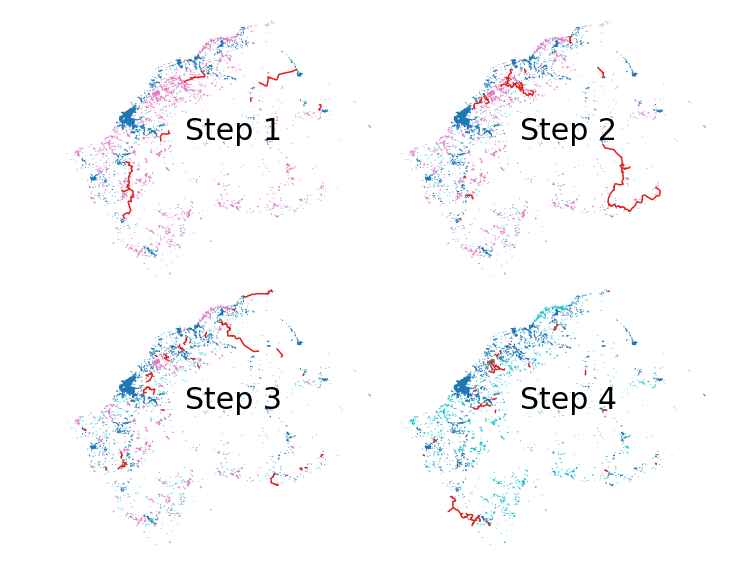

In [10]:
dynamic_model = nm.dynamic(steps=4, years_per_step=5, demand_factor=5)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
features = {}
results = {}

for i, ((t, n, r), ax) in enumerate(zip(dynamic_model, (ax1, ax2, ax3, ax4))):
    features[f't{i+1}'] = t
    features[f'n{i+1}'] = n
    results[i+1] = r
    
    n.plot(ax=ax, column='existing', cmap='Set1')
    t.plot(ax=ax, column='type', cmap='tab10')
    ax.text(nm.x_mean, nm.y_mean, f'Step {i+1}', dict(size=30))
    ax.axis('off')

io.save_to_path(national_out, **features)
plt.subplots_adjust(hspace=-0.3, wspace=0.0)
plt.show()

In [11]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
summary = pd.DataFrame(results)
summary.columns = [f'Step {c}' for c in summary.columns]
summary

,Step 1,Step 2,Step 3,Step 4
already-elec-pop,1149850,1308386,1577748,1808748
cost-densify,0,0,0,0
cost-grid,232668908,547482209,463491230,452013192
cost-off-grid,16443917,42611950,94668648,392835510
densify,323,385,508,603
densify-pop,0,0,0,0
model-pop,2579344,2708311,2843726,2985913
new-conn-pop,96232,194231,144869,178189
new-grid,62,123,95,73
new-off-grid,274,487,658,805


# Run a single simulation for the whole time period

In [12]:
nm.setup(sort_by='pop')
nm.initial_access()
nm.demand_levels(factor=5)
nm.connect_targets()
nm.model()
nm.spatialise()
results = nm.summary()
nm.save_to_path(national_out)

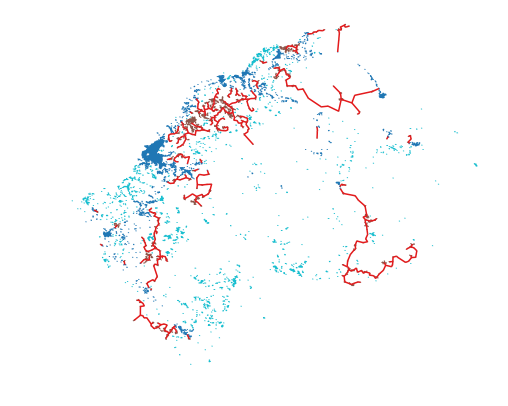

In [13]:
fig, ax = plt.subplots(figsize=(8,8))  
nm.network_out.plot(ax=ax, column='existing', cmap='Set1')
nm.targets_out.plot(ax=ax, column='type', cmap='tab10')
ax.axis('off')
plt.show()

In [14]:
print('\t\t\t')
print(f'New grid: {results["new-grid"]} at cost {results["cost-grid"]:,.0f}')
print(f'New off-grid: {results["new-off-grid"]} at cost {results["cost-off-grid"]:,.0f}')
print(f'Densify: {results["densify"]} at cost {results["cost-densify"]:,.0f}')
print()
print(f'Total cost ${results["tot-cost"]:,.0f}')
print()
print(f'Modelled pop: {results["model-pop"]:,.0f}')
print(f'Currently electrified pop: {results["already-elec-pop"]:,.0f}')
print(f'Densify pop: {results["densify-pop"]:,.0f}')
print(f'New extentions pop: {results["new-conn-pop"]:,.0f}')
print(f'Off-grid pop: {results["new-og-pop"]:,.0f}')

			
New grid: 439 at cost 2,042,721,974
New off-grid: 719 at cost 356,382,870
Densify: 323 at cost 877,809,857

Total cost $3,276,914,700

Modelled pop: 2,985,913
Currently electrified pop: 866,742
Densify pop: 464,353
New extentions pop: 780,132
Off-grid pop: 874,686


# Local

In [16]:
buildings_in = test_data / 'buildings.geojson'
local_out = test_output / 'local'

In [17]:
lm = LocalModel(data=buildings_in)
lm.setup(sort_by='area',
         min_area=0)  # m2, exclude buildings with area below this

In [19]:
m = folium.Map([lm.y_mean, lm.x_mean],
               zoom_start=15,
               control_scale=True)

popup_html = '<p>Latitude: " + lat + "</p><p>Longitude: " + lng + "</p>'
folium.ClickForMarker(popup=popup_html).add_to(m)
folium.GeoJson(lm.targets).add_to(m)
print('Click on the desired location for the PV point.')
m

Click on the desired location for the PV point.


In [20]:
latitude = -29.5432
longitude = 28.1339

In [21]:
lm.connect_targets(origin=(latitude, longitude))

In [22]:
lm.parameters(demand=8,             # average demand in kWh/person/month
              tariff=0.2,          # USD/kWh charged
              gen_cost=4000,        # USD/kW for installation, excluding distribution network
              cost_wire=20,         # USD per metre
              cost_connection=140,  # USD per connection/node
              opex_ratio=0.02,      # % of capex per year (values above 1 are divided by 100)
              years=20,             # years over which to amortize (and maintain)
              discount_rate=0.06)   # discount rate (values above 1 are divided by 100)

In [23]:
lm.model()

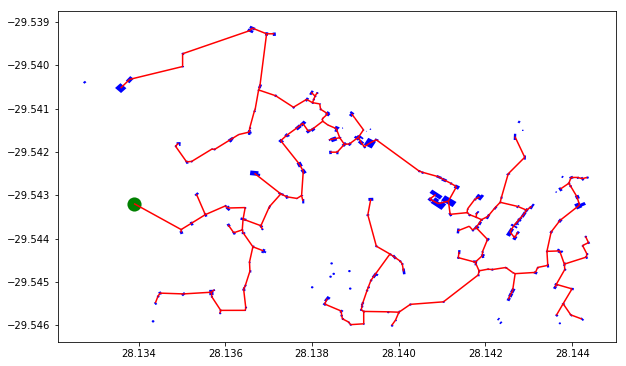

In [24]:
lm.spatialise()

fig, ax = plt.subplots(figsize=(10,10))
lm.network_out.loc[lm.network_out['enabled'] == 1].plot(ax=ax, color='red')
lm.targets_out.plot(ax=ax, color='blue')
ax.scatter(longitude, latitude, s=200, lw=0, c='green')
plt.show()

In [25]:
lm.save_to_path(local_out)
print('Results saved to', local_out.absolute())

Results saved to /home/chris/Code/openelec/test_output/local


In [26]:
results = lm.summary()
print(f'Total houses connected: {results["connected"]} out of {len(lm.targets_out)-1}')
print(f'Generator installation size: {results["gen-size"]:.0f} kW')
print(f'Total length of lines is {results["line-length"]:.0f}m')
print(f'CAPEX: ${results["capex"]:.0f}')
print(f'Annual OPEX: ${results["opex"]:.0f}')
print(f'Annual Income: ${results["income"]:.0f}')
print(f'NPV over {lm.years} years is ${lm.results["npv"]:.0f}')

Total houses connected: 217 out of 235
Generator installation size: 123 kW
Total length of lines is 5943m
CAPEX: $644488
Annual OPEX: $12889
Annual Income: $35657
NPV over 20 years is $-390439
